In [87]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import norm


import matplotlib as mpl
from matplotlib import cm
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from astroML.datasets import fetch_rrlyrae_combined
from astroML.classification import GMMBayes
from astroML.utils import split_samples
from astroML.datasets import fetch_imaging_sample


import time


In [6]:
# Required Fucntions
def plot_timeseries(df: pd.DataFrame, indx=0 ) -> None:
    '''Plot the generated time series data.
        Args:
            df: Pandas DataFrame with the generated data
            indx: index of the time series to plot
        '''
    df[f'y{indx}' ].plot(style='o')  

    plt.show()


# Section 1: Gussian Mixture Model

 - develop 3 approaches for classifying time series
 - the initial approach should extract features from a time series (e.g. using cesium-ml) and apply a GMM classifier (you will need to define how you will classify a continuous function such as period). 
 - The classifier should be robust to changes in the phase of the time series

## Part 1: Timesseries with single frequency (at different phases)

### Read in time-series data

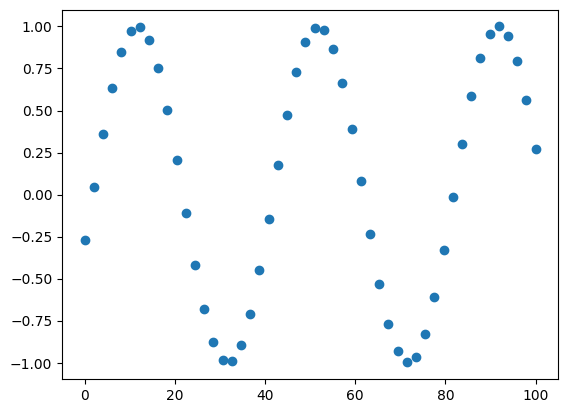

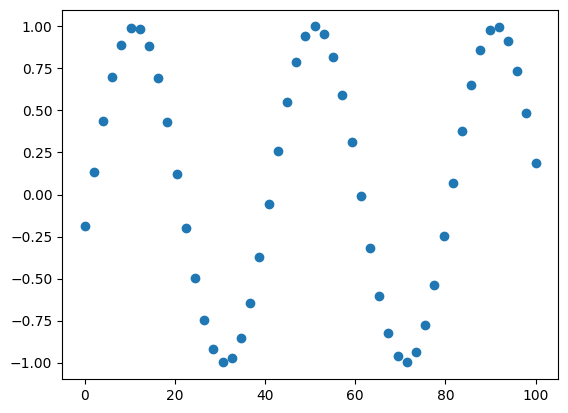

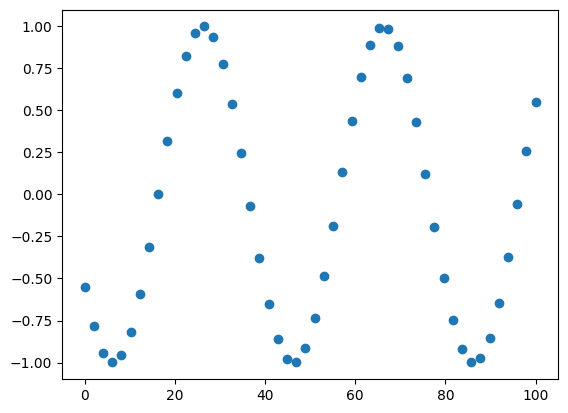

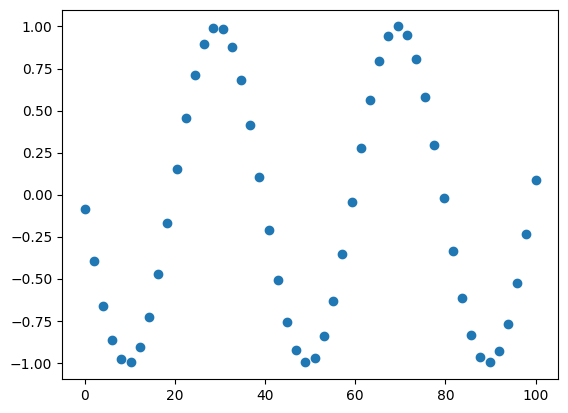

(50, 100000)


,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y99990,y99991,y99992,y99993,y99994,y99995,y99996,y99997,y99998,y99999
0.000000,-0.987242,-0.735776,-0.835780,0.368300,0.993337,0.607363,0.991060,0.913201,0.988297,-0.428671,...,-0.952394,-0.604454,-0.980924,-0.895995,0.947058,0.995710,0.072077,0.894138,-0.717289,-0.824622
2.040816,-0.886773,-0.484893,-0.966216,0.056579,0.906416,0.826751,0.982612,0.738269,0.986016,-0.122144,...,-0.999942,-0.322633,-0.869696,-0.710421,0.797642,0.915826,0.382694,0.707484,-0.461188,-0.960864
4.081633,-0.695953,-0.184606,-0.998207,-0.260906,0.727141,0.961903,0.874048,0.488116,0.883272,0.196827,...,-0.945608,-0.007939,-0.669857,-0.452464,0.566956,0.742629,0.654319,0.448745,-0.158096,-0.999205
6.122449,-0.434223,0.134491,-0.928491,-0.551809,0.473780,0.999047,0.676428,0.188229,0.690533,0.495744,...,-0.794927,0.307564,-0.401767,-0.148405,0.278503,0.493768,0.859276,0.144284,0.161103,-0.935738
8.163265,-0.128251,0.439885,-0.764173,-0.786488,0.172146,0.934401,0.409888,-0.130836,0.427436,0.744150,...,-0.563253,0.591730,-0.092741,0.170774,-0.038327,0.194597,0.976682,-0.174877,0.463888,-0.776931


In [58]:
ts_single_freq_df = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_single_frequency.feather')
ts_single_freq_df.head()
plot_timeseries(ts_single_freq_df, indx=34)
plot_timeseries(ts_single_freq_df, indx=82)
plot_timeseries(ts_single_freq_df, indx=11)
plot_timeseries(ts_single_freq_df, indx=95697)

print(ts_single_freq_df.shape)
ts_single_freq_df.head()

In [34]:
# # df_A = pd.read_csv('/home/jovyan/COURSE_MATERIALS/lectures/data/fieldA.csv')
# df_A = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency_sampled.feather')
# df_A.head()
# plot_timeseries(df_A, indx=10)

### Read in periods

In [35]:
import pandas as pd

# Read data from pickle file
single_freq_periods = np.array(pd.read_pickle('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/periods_single_freq.pkl'))

# Display the dataframe
single_freq_periods.shape

(100000,)

### Part 1: Using cesium-ml to extract features

In [36]:
from cesium import featurize #!Takes 10 minutes to run

features_to_use = [
    "amplitude",  # The difference between the maximum and minimum of the time series
    "percent_beyond_1_std",  # The percentage of points more than one standard deviation from the mean
    "maximum",  # The maximum value of the time series
    "max_slope",  # The maximum slope between two consecutive points in the time series
    "median",  # The median value of the time series
    "median_absolute_deviation",  # The median of the absolute deviations from the time series median
    "percent_close_to_median",  # The percentage of points within a threshold of the median
    "minimum",  # The minimum value of the time series
    "skew",  # The skewness of the time series, measuring the asymmetry of the probability distribution
    "std",  # The standard deviation of the time series
    "weighted_average",  # The average value of the time series, weighted by the values themselves
    "period_fast"  # The period of the most significant frequency component, computed using a fast algorithm
]

fset_cesium = featurize.featurize_time_series(
    times=np.array(ts_single_freq_df.index),
    values=np.array(ts_single_freq_df[:].transpose()),
    errors=None,
    features_to_use=features_to_use,
)

fset_cesium.shape

(1, 1200000)

In [37]:
# # Save the featurized data !Takes 4 minutes to run
# fset_cesium.to_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/featurized_single_freq.csv')
# fset_cesium.to_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/featurized_single_freq.feather')

### Visualize Cesium features for timeseries

In [42]:
fset_cesium['weighted_average'].loc[0].describe()

count    100000.000000
mean          0.000336
std           0.087394
min          -0.123707
25%          -0.086713
50%           0.000277
75%           0.087626
max           0.123707
Name: 0, dtype: float64

<Axes: xlabel='0', ylabel='Count'>

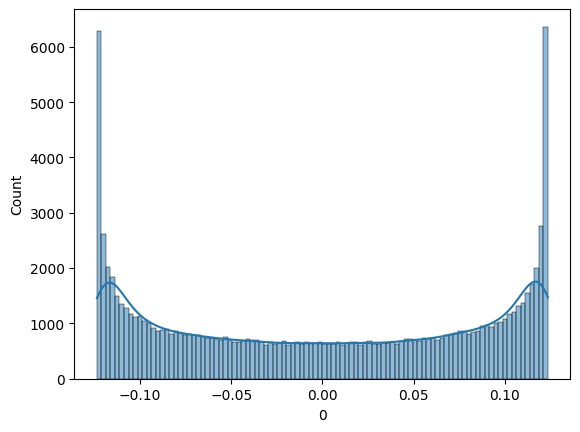

In [43]:
sns.histplot(fset_cesium['weighted_average'].loc[0], bins=100, kde=True)

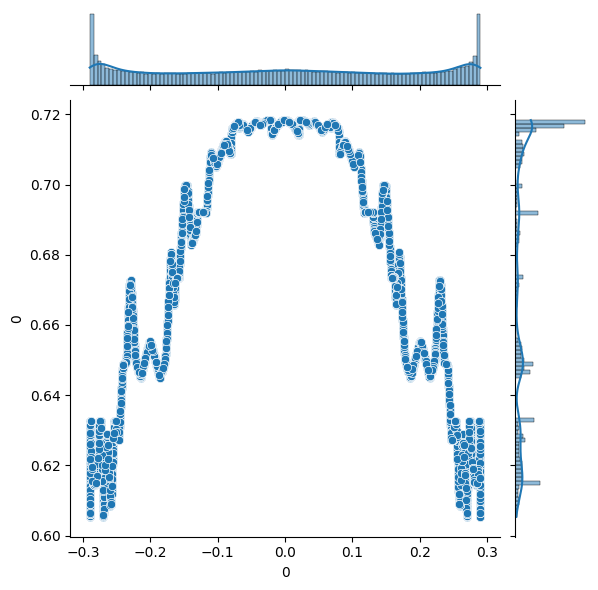

In [50]:
# Assuming you have two features 'feature1' and 'feature2' in your fset_cesium DataFrame
feature1 = fset_cesium['skew'].loc[0]
feature2 = fset_cesium['median_absolute_deviation'].loc[0]

sns.jointplot(x=feature1, y=feature2, kind='scatter', marginal_kws=dict(bins=100, kde=True))
plt.xlabel(f'{feature1.name}')
plt.ylabel(f'{feature2.name}')

plt.show()

### Formating feature dataframe for GMMBayes classifyer

In [54]:
# Create feature dataframe for data split and model training
feature_df = np.reshape(fset_cesium[['median', 'amplitude']], (-1, 2))
print(feature_df.shape)
# If we want to read in the complete timeseries
print(ts_single_freq_df.transpose().shape)

print(np.array(single_freq_periods).shape)



(100000, 2)
(100000, 50)
(100000,)


Use Decrete fourier transfrom to descrtize the the contious function of period

#### Data Split

In [56]:
# Data Split
X = np.array(feature_df) # (100000,)
y = np.array(single_freq_periods)

(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)
print(f'Training set N={len(X_train)}, Shape:{X_train.shape}\nTesting set N={len(X_test)}, Shape:{X_test.shape} \nValidation set N={len(X_valid)}, Shape:{X_valid.shape}\n') 
print(f'Training set N={len(y_train)}, Shape:{y_train.shape}\nTesting set N={len(y_test)}, Shape:{y_test.shape} \nValidation set N={len(y_valid)}, Shape:{y_valid.shape}') 

Training set N=80000, Shape:(80000, 2)
Testing set N=10000, Shape:(10000, 2) 
Validation set N=10000, Shape:(10000, 2)

Training set N=80000, Shape:(80000,)
Testing set N=10000, Shape:(10000,) 
Validation set N=10000, Shape:(10000,)


### Gussian Mixture Model Bayes

In [ ]:
# Apply GMM classifers to training set
# labels = ['median', 'amplitude']

# train a Gaussian Mixture Bayes classifier with 2 gaussians for each class
gmmb = GMMBayes(n_components=4, random_state=0)
gmmb.fit(X_train, y_train)

print(f'Accuracy: {gmmb.score(X_valid, y_valid)}')

In [ ]:
y_pred = gmmb.predict(X_valid)

# when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
# print('Stars vs Galaxies Recall %0.3f' % recall_score(y_valid, y_pred))
# print('Stars vs Galaxies Precision %0.3f' % precision_score(y_valid, y_pred))

threshold = 0.5  # Set the threshold for classification 
y_pred_discrete = np.where(y_pred >= threshold, 1, 0)  # Convert continuous predictions to discrete values


print(classification_report(y_valid, y_pred))

In [ ]:
y_pred = gmmb.predict(X_valid)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax)
plt.show()

# when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
print('RR Lyrae Recall %0.3f' % recall_score(y_valid, y_pred))
print('RR Lyrae Precision %0.3f' % precision_score(y_valid, y_pred))

## Part 2 Timeseries of Mulitple Frequency(at different frequencies)

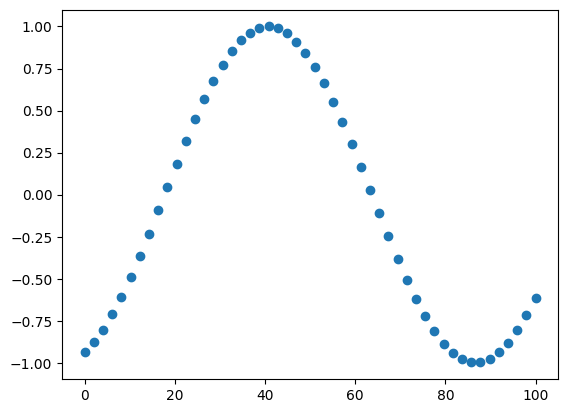

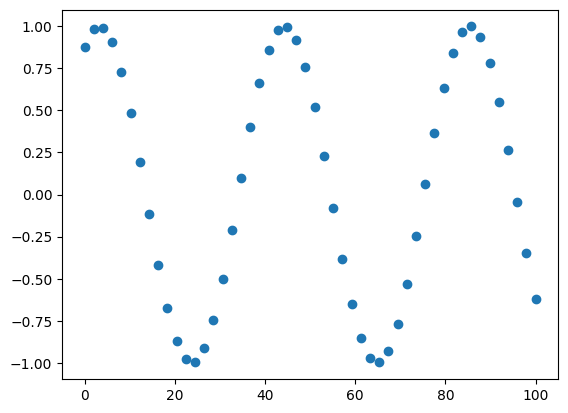

In [7]:
ts_multi_freq_df = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency.feather')
ts_multi_freq_df.head()
plot_timeseries(ts_multi_freq_df, indx=10)
plot_timeseries(ts_multi_freq_df, indx=25)

### Cesium features for timeseries

In [8]:
from cesium import featurize #!Takes 10 minutes to run
ts_time = np.array(ts_multi_freq_df.index)
lightcurve_val = np.array(ts_multi_freq_df[:].transpose())

features_to_use = [
    "amplitude",  # The difference between the maximum and minimum of the time series
    "percent_beyond_1_std",  # The percentage of points more than one standard deviation from the mean
    "maximum",  # The maximum value of the time series
    "max_slope",  # The maximum slope between two consecutive points in the time series
    "median",  # The median value of the time series
    "median_absolute_deviation",  # The median of the absolute deviations from the time series median
    "percent_close_to_median",  # The percentage of points within a threshold of the median
    "minimum",  # The minimum value of the time series
    "skew",  # The skewness of the time series, measuring the asymmetry of the probability distribution
    "std",  # The standard deviation of the time series
    "weighted_average",  # The average value of the time series, weighted by the values themselves
    "period_fast"  # The period of the most significant frequency component, computed using a fast algorithm
]

multifreq_fset_cesium = featurize.featurize_time_series(
    times=ts_time,
    values=lightcurve_val,
    errors=None,
    features_to_use=features_to_use,
)

multifreq_fset_cesium.shape

(1, 1200000)

In [ ]:
# # From Tobin's code to make cesium dataframe with decreate values as the periods 
# periods = multifreq_fset_cesium['period_fast'].values[0][:]
# %%time
# Read in timesseries data
df_multiple = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency.feather')

# Set feature list you want from cesium 
features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "period_fast",
    "weighted_average",
]


# Create a list of cesium features including periods
cesium_results=[]
periods=[]

for i in range(100000):
    fset_cesium = featurize.featurize_time_series(
        times=df_multiple[f'y'+str(i)].index[np.isfinite(df_multiple[f'y'+str(i)].values)],
        values=df_multiple[f'y'+str(i)].values[np.isfinite(df_multiple[f'y'+str(i)].values)],
        errors=None,
        features_to_use=features_to_use,
    )
    
    cesium_results.append(fset_cesium)
    periods.append(fset_cesium.period_fast.values[0][0])
    
    
cesium_results[0]



# Bin periods in to ranges to descitize the contiouns label    
# cesium_results[0]
classes=np.zeros(len(periods))
for i in range(len(periods)):
    classes[i]=int((np.array(periods[i])-40)/5)


# periods = np.array(pd.read_pickle('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/periods_multiple_freq.pkl'))
# Set features and truth labels - X, y for appending values
X=np.zeros((len(periods), len(features_to_use)-1))
y = classes
print(f'y: {y}')
labels = ['Period_U40', 'Period_40_45', 'Period_45_50', 'Period_50_55', 'Period_55_60', 'Period_60_65', 'Period_65_70', 
          'Period_70_75', 'Period_75_80', 'Period_80_85', 'Period_85_90', 'Period_90_95', 'Period_95_100']


for i in range(len(periods)):
    X[i]= cesium_results[i]['amplitude'].values[0][0], cesium_results[i]['percent_beyond_1_std'].values[0][0], cesium_results[i]['maximum'].values[0][0], cesium_results[i]['max_slope'].values[0][0], cesium_results[i]['median'].values[0][0], cesium_results[i]['median_absolute_deviation'].values[0][0], cesium_results[i]['percent_close_to_median'].values[0][0], cesium_results[i]['minimum'].values[0][0], cesium_results[i]['skew'].values[0][0], cesium_results[i]['std'].values[0][0], cesium_results[i]['weighted_average'].values[0][0]   

y = classes
print(f'y: {y}')

# Data Split
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)

gmmb = GMMBayes(n_components=4, random_state=0)
gmmb.fit(X_train, y_train)

y_pred = gmmb.predict(X_valid)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax, normalize='true', xticks_rotation=45)
plt.title(f'Precision=')
plt.show()

Stellar Type Recall 0.924
Stellar Type Precision 0.925


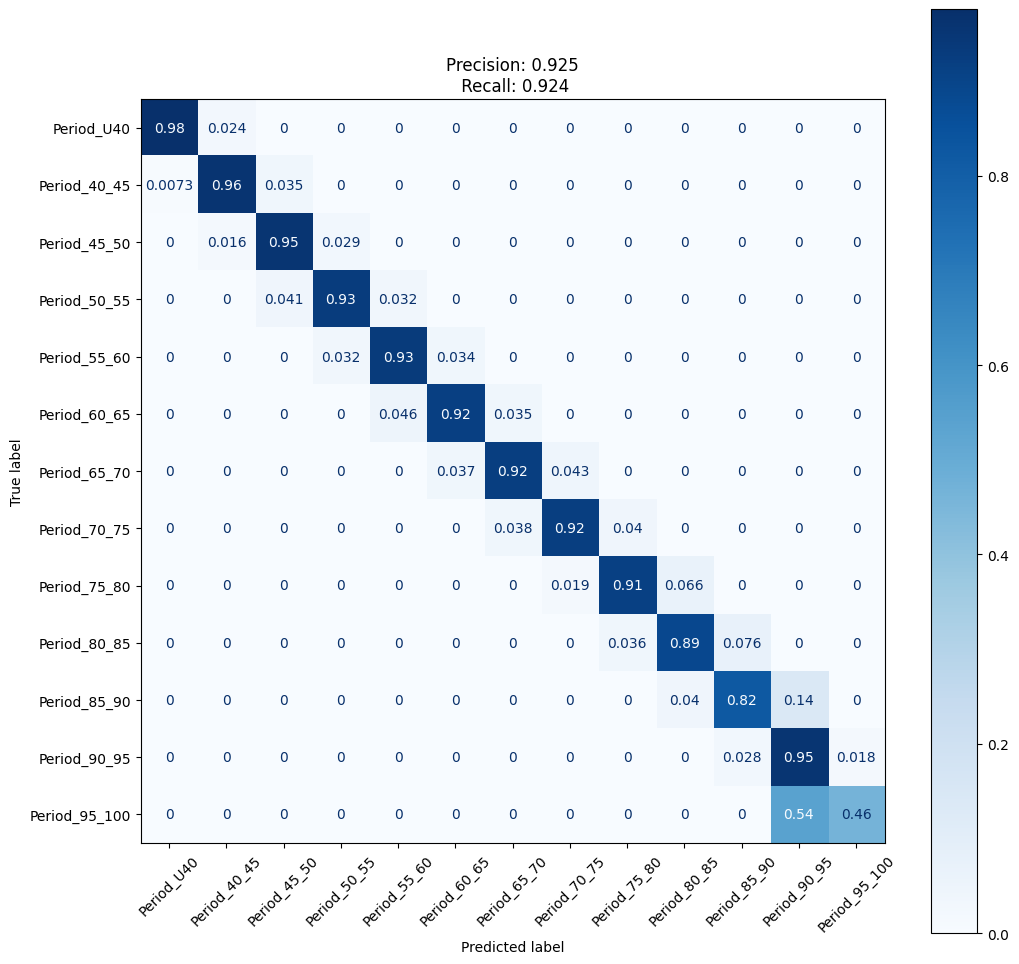

In [98]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax, normalize='true', xticks_rotation=45)
print('Stellar Type Recall %0.3f' % recall_score(y_valid, y_pred, average='weighted'))
print('Stellar Type Precision %0.3f' % precision_score(y_valid, y_pred, average='weighted'))
plt.title(f'Precision: {np.round(precision_score(y_valid, y_pred, average="weighted"), 3)}\n Recall: {np.round(recall_score(y_valid, y_pred, average="weighted"), 3)}')
plt.show()

### visualize features for multiple frequencies

In [51]:
multifreq_fset_cesium['period_fast'].loc[0].describe()

count    100000.000000
mean         69.818074
std          17.264890
min          39.904230
25%          54.824561
50%          69.686445
75%          84.745763
max         100.200401
Name: 0, dtype: float64

<Axes: xlabel='0', ylabel='Count'>

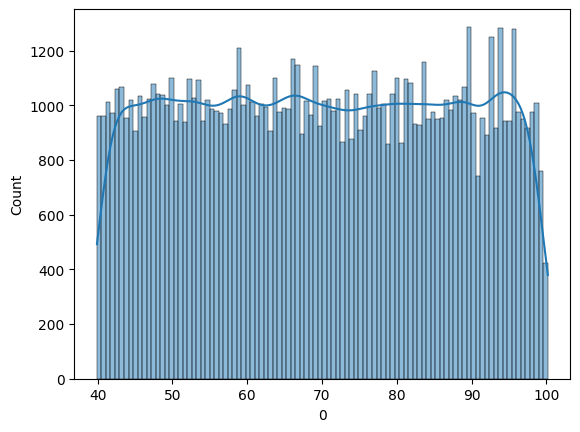

In [52]:
sns.histplot(multifreq_fset_cesium['period_fast'].loc[0], bins=100, kde=True)
plt.title('Period')

<Axes: xlabel='0', ylabel='Count'>

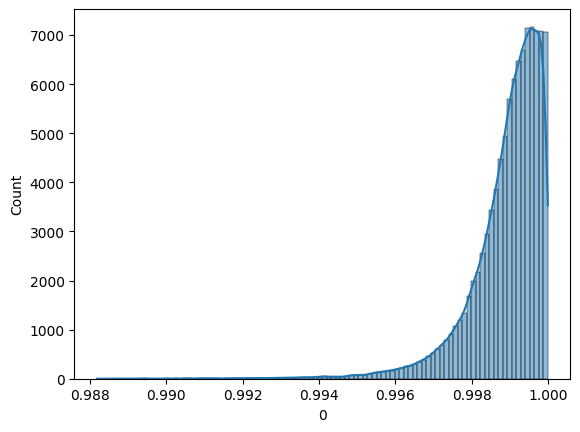

In [17]:
sns.histplot(multifreq_fset_cesium[['amplitude']].loc[0], bins=100, kde=True)

### Set period as a classifyer

In [18]:
multifreq_fset_cesium_periods = np.reshape(multifreq_fset_cesium['period_fast'].loc[0], (1, -1))
multifreq_fset_cesium_periods.shape

(1, 100000)

### Bin the period values into discrete classes and set values to the range of the periods

In [20]:
multifreq_fset_cesium_periods

array([[92.42144177, 85.61643836, 88.33922261, ..., 52.63157895,
        88.18342152, 88.96797153]])

In [23]:
periods = np.arange(40, 120, 5)
periods

array([ 40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100,
       105, 110, 115])

In [61]:
import numpy as np

# Define the periods from 40-100 in increments of 10
periods = np.arange(40, 120, 5)
print(f'T: {periods}')

# Set labels for each element in multifreq_fset_cesium_periods
labels = []
for period in multifreq_fset_cesium_periods.flatten():
    label = None
    for i in range(len(periods)):
        if period < periods[i]:
            label = f'p<{periods[i]}'
            break
    if label is None:
        label = f'p>{periods[-1]}'
    labels.append(label)

# Print the labels
print(np.array(labels).shape)


T: [ 40  45  50  55  60  65  70  75  80  85  90  95 100 105 110 115]
(100000,)


In [62]:
unique, counts = np.unique(np.array(labels), return_counts=True)

print(dict(zip(unique, counts)))
print(f'Sum of the counts: {sum(counts)}')

{'p<100': 7773, 'p<105': 132, 'p<40': 51, 'p<45': 8348, 'p<50': 8424, 'p<55': 8408, 'p<60': 8479, 'p<65': 8242, 'p<70': 8515, 'p<75': 8194, 'p<80': 8200, 'p<85': 8411, 'p<90': 8548, 'p<95': 8275}
Sum of the counts: 100000


In [63]:
X = np.reshape(multifreq_fset_cesium[['amplitude', 'percent_beyond_1_std']].loc[0], (-1, 2)) #(100000, 2) 
X.shape

(100000, 2)

In [80]:
multifreq_fset_cesium[:].loc[0]

feature      channel
amplitude    0           0.998576
             1           0.999000
             2           0.999417
             3           0.999153
             4           0.997999
                          ...    
period_fast  99995      64.516129
             99996      41.220115
             99997      52.631579
             99998      88.183422
             99999      88.967972
Name: 0, Length: 1200000, dtype: float64

### Data Split

In [81]:
# Data Split
# X = np.reshape(multifreq_fset_cesium[['amplitude', 'percent_beyond_1_std']].loc[0], (-1, 2)) #(100000, 2) 
X = np.reshape(multifreq_fset_cesium[:].loc[0], (-1, 12)) #(100000, 12) 

print(X.shape)
# X = np.reshape(ts_multi_freq_df[:], (-1,50)) #(100000, 50) # lightcurve values
y = np.array(labels) #(100000,)
print(y.shape)

(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)
print(f'Training set N={len(X_train)}, Shape:{X_train.shape}\nTesting set N={len(X_test)}, Shape:{X_test.shape} \nValidation set N={len(X_valid)}, Shape:{X_valid.shape}\n') 
print(f'Training set N={len(y_train)}, Shape:{y_train.shape}\nTesting set N={len(y_test)}, Shape:{y_test.shape} \nValidation set N={len(y_valid)}, Shape:{y_valid.shape}') 

(100000, 12)
(100000,)
Training set N=80000, Shape:(80000, 12)
Testing set N=10000, Shape:(10000, 12) 
Validation set N=10000, Shape:(10000, 12)

Training set N=80000, Shape:(80000,)
Testing set N=10000, Shape:(10000,) 
Validation set N=10000, Shape:(10000,)


### Guassian Mixture Model

In [82]:
# Apply GMM classifers to training set
# labels = ['median', 'amplitude']

# train a Gaussian Mixture Bayes classifier with 2 gaussians for each class
gmmb = GMMBayes(n_components=8, random_state=0)
gmmb.fit(X_train, y_train)

print(f'Training Accuracy: {gmmb.score(X_train, y_train)}')
print(f'Validation Accuracy: {gmmb.score(X_valid, y_valid)}')
print(f'Testing Accuracy: {gmmb.score(X_test, y_test)}')

y_pred = gmmb.predict(X_valid)
print(classification_report(y_valid, y_pred))

print('Stellar Type Recall %0.3f' % recall_score(y_valid, y_pred, average='weighted'))
print('Stellar Type Precision %0.3f' % precision_score(y_valid, y_pred, average='weighted'))

Training Accuracy: 0.0679875
Validation Accuracy: 0.0432
Testing Accuracy: 0.0437
              precision    recall  f1-score   support

       p<100       0.06      0.01      0.02       815
       p<105       0.00      0.38      0.00        13
        p<40       0.00      0.00      0.00         7
        p<45       0.08      0.01      0.02       876
        p<50       0.08      0.02      0.04       827
        p<55       0.08      0.02      0.03       853
        p<60       0.09      0.17      0.12       839
        p<65       0.08      0.03      0.04       784
        p<70       0.07      0.04      0.05       802
        p<75       0.08      0.09      0.09       837
        p<80       0.07      0.05      0.06       824
        p<85       0.06      0.01      0.02       874
        p<90       0.10      0.03      0.05       858
        p<95       0.06      0.01      0.02       791

    accuracy                           0.04     10000
   macro avg       0.07      0.06      0.04     1000

In [83]:
print('Stellar Type Recall %0.3f' % recall_score(y_valid, y_pred, average='weighted'))
print('Stellar Type Precision %0.3f' % precision_score(y_valid, y_pred, average='weighted'))

Stellar Type Recall 0.043
Stellar Type Precision 0.076


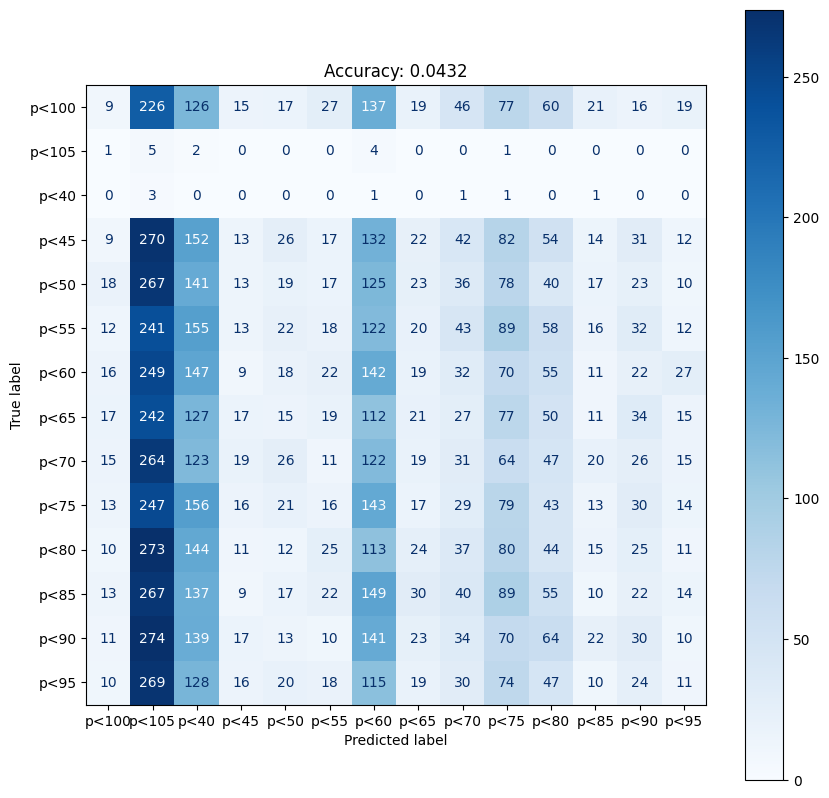

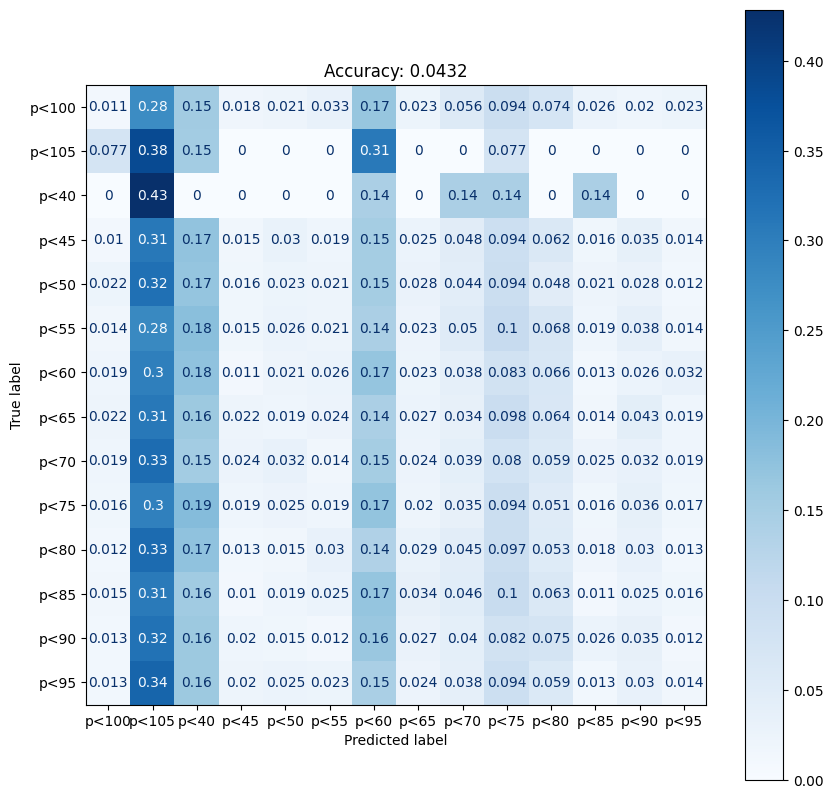

In [84]:
# labels_list = ['p<40', 'p<50', 'p<60', 'p<70', 'p<80', 'p<90', 'p<100', 'p>100']
labels_list = unique
y_pred = gmmb.predict(X_valid)

# n_components = len(np.unique(y_valid))
# gmmb = GMMBayes(n_components=n_components, random_state=0)
# gmmb.fit(X_valid, y_valid)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels_list, cmap='Blues', ax=ax)
# plt.title(f'Recall:{}, Precision:{}')
plt.title(f'Accuracy: {gmmb.score(X_valid, y_valid)}')
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels_list, cmap='Blues', ax=ax, normalize='true')
plt.title(f'Accuracy: {gmmb.score(X_valid, y_valid)}')
plt.show()

In [215]:
# # make the plots look nice
# mpl.rcParams['figure.dpi'] = 150
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.rc('legend', fontsize='x-small')
# cmap = cm.get_cmap('viridis')
# def scatter_gmmb(ax, i, j):
#     idx = [i,j]
#     rows = [[i, i], [j, j]]
#     cols = [[i, j], [i, j]]
        
#     for k in range(2): # for each class
#         for l in range(gmmb.gmms_[k].n_components): # for each Gaussian
#             covariance = gmmb.gmms_[k].covariances_[l][rows, cols]
            
#             v, angle = covariance_to_vangle(covariance)
            
#             ell = mpl.patches.Ellipse(gmmb.gmms_[k].means_[l, idx], v[0], v[1],
#                                       180 + angle, ec=cmap(float(k)), fill=False)
#             ell.set_alpha(gmmb.gmms_[k].weights_[l])
#             ax.add_artist(ell)

# def hist_gmmb(ax, i):
#     plotx = np.linspace(np.min(X[:,i]), np.max(X[:,i]), 100)
#     for k in range(2): # for each class
#         for l in range(gmmb.gmms_[k].n_components): # for each Gaussian
#             dist = norm(loc=gmmb.gmms_[k].means_[l,i], scale=np.sqrt(gmmb.gmms_[k].covariances_[l][i,i]))
#             plt.plot(plotx, dist.pdf(plotx), color=cmap(float(k)), alpha=gmmb.gmms_[k].weights_[l])
# # # make the plots look nice
# # mpl.rcParams['figure.dpi'] = 150
# # plt.rc('xtick', labelsize='x-small')
# # plt.rc('ytick', labelsize='x-small')
# # plt.rc('legend', fontsize='x-small')
# # cmap = cm.get_cmap('viridis')

# # def plot_rrlyrae(scatterfn=None, histfn=None):    
# #     fig = plt.figure(figsize=(6,6))
# #     fig.subplots_adjust(hspace=0, wspace=0)

# #     # loop through every possible pair of features
# #     for i in range(4):
# #         for j in range(4):
# #             # only make subplots in the lower diagonal
# #             if i <= j:
# #                 ax = plt.subplot(4,4,i+j*4+1)
# #                 # if this subplot is on the left side (but not the top), make a y label
# #                 if i == 0 and j != 0:
# #                     ax.set_ylabel(features[j])
# #                 # if this subplot is on the bottom, make an x label
# #                 if j == 3:
# #                     ax.set_xlabel(features[i])
# #                 # remove ticks on interior plots
# #                 if i != 0:
# #                     ax.set_yticks([])
# #                 if j != 3:
# #                     ax.set_xticks([])
# #                 # scatter plots in off diagonals
# #                 if i < j:
# #                     ax.scatter(X[y==0,i], X[y==0,j], s=1, marker='.', c=y[y==0], vmin=0, vmax=1, alpha=0.005)
# #                     ax.scatter(X[y==1,i], X[y==1,j], s=1, marker='.', c=y[y==1], vmin=0, vmax=1, alpha=0.25)
# #                     if scatterfn is not None:
# #                         scatterfn(ax, i, j)
# #                     ax.set_xlim(np.min(X[:,i]), np.max(X[:,i]))
# #                     ax.set_ylim(np.min(X[:,j]), np.max(X[:,j]))
# #                 # normalized histograms on diagonals, with same colour map as scatter plots
# #                 if i == j:
# #                     plt.hist([X[y == 0, i], X[y == 1, i]], density=True, histtype='stepfilled',\
# #                              label=labels, color=[cmap(0.), cmap(1.)], alpha=0.5)

# #                     if histfn is not None:
# #                         histfn(ax, i)

# #                     plt.yticks([]) # don't want counts in the y-axis
# #                     # add a legend
# #                     if i == 0:
# #                         plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', title='labels')
# #     plt.show()

# # plot_rrlyrae(scatterfn=scatter_gmmb, histfn=hist_gmmb)

#### preform cross validation to select the right number of components
- Fit training model with different number of componets and see which one preformes best of the validation set

In [203]:
# valid_acc = []
# comp = np.arange(3,10,1)

# for component in comp:
#     print(type(component))
#     gmmb = GMMBayes(n_components=comp, random_state=0)
#     gmmb.fit(X_train, y_train)
#     print(f'Training Accuracy: {gmmb.score(X_train, y_train)}')
#     print(f'Validation Accuracy: {gmmb.score(X_valid, y_valid)}')
#     valid_acc.append(gmmb.score(X_valid, y_valid))
#     print(f'Testing Accuracy: {gmmb.score(X_test, y_test)}')

In [205]:
np.unique(np.array(labels))

array(['p<100', 'p<110', 'p<40', 'p<50', 'p<60', 'p<70', 'p<80', 'p<90'],
      dtype='<U5')

In [202]:
# y_pred = gmmb.predict(X_valid)
# labels_list = ['p<40', 'p<50', 'p<60', 'p<70', 'p<80', 'p<90', 'p<100', 'p>100']

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot()
# # plt.figure(figsize=(10,10))
# ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels_list, cmap='Blues', ax=ax)
# plt.show()

# # when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
# # print('RR Lyrae Recall %0.3f' % recall_score(y_valid, y_pred))
# # print('RR Lyrae Precision %0.3f' % precision_score(y_valid, y_pred))

## Part 3: Timeseries Multiple Frequency Sampled

y: [10.  9.  9. ...  2.  9.  9.]
y: [10.  9.  9. ...  2.  9.  9.]
Stellar Type Recall 0.843
Stellar Type Precision 0.843


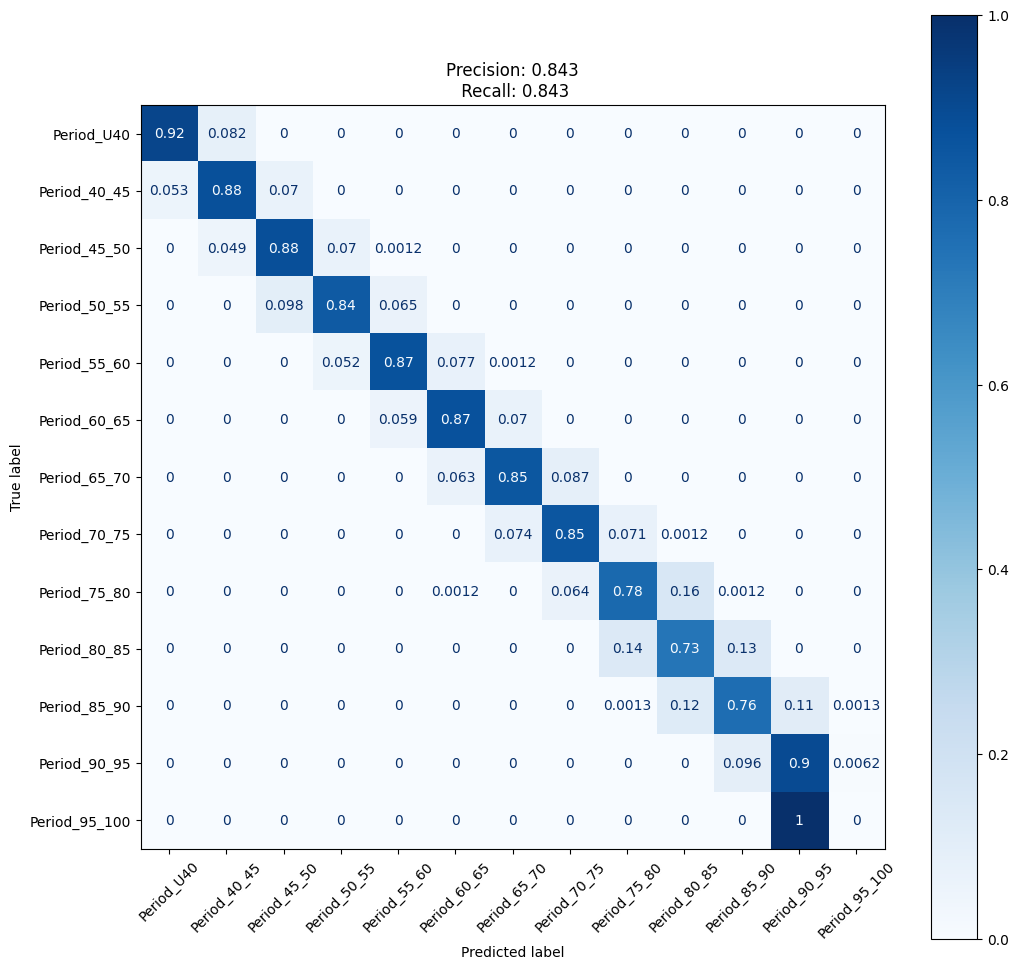

In [99]:
# # From Tobin's code to make cesium dataframe with decreate values as the periods 
# Read in timesseries data
df_multiple = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency_sampled.feather')

# Set feature list you want from cesium 
features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "period_fast",
    "weighted_average",
]


# Create a list of cesium features including periods
cesium_results=[]
periods=[]

for i in range(100000):
    fset_cesium = featurize.featurize_time_series(
        times=df_multiple[f'y'+str(i)].index[np.isfinite(df_multiple[f'y'+str(i)].values)],
        values=df_multiple[f'y'+str(i)].values[np.isfinite(df_multiple[f'y'+str(i)].values)],
        errors=None,
        features_to_use=features_to_use,
    )
    
    cesium_results.append(fset_cesium)
    periods.append(fset_cesium.period_fast.values[0][0])
    
    
cesium_results[0]



# Bin periods in to ranges to descitize the contiouns label    
# cesium_results[0]
classes=np.zeros(len(periods))
for i in range(len(periods)):
    classes[i]=int((np.array(periods[i])-40)/5)


# periods = np.array(pd.read_pickle('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/periods_multiple_freq.pkl'))
# Set features and truth labels - X, y for appending values
X=np.zeros((len(periods), len(features_to_use)-1))
y = classes
print(f'y: {y}')
labels = ['Period_U40', 'Period_40_45', 'Period_45_50', 'Period_50_55', 'Period_55_60', 'Period_60_65', 'Period_65_70', 'Period_70_75', 'Period_75_80', 'Period_80_85', 'Period_85_90', 'Period_90_95', 'Period_95_100']


for i in range(len(periods)):
    X[i]= cesium_results[i]['amplitude'].values[0][0], cesium_results[i]['percent_beyond_1_std'].values[0][0], cesium_results[i]['maximum'].values[0][0], cesium_results[i]['max_slope'].values[0][0], cesium_results[i]['median'].values[0][0], cesium_results[i]['median_absolute_deviation'].values[0][0], cesium_results[i]['percent_close_to_median'].values[0][0], cesium_results[i]['minimum'].values[0][0], cesium_results[i]['skew'].values[0][0], cesium_results[i]['std'].values[0][0], cesium_results[i]['weighted_average'].values[0][0]   

y = classes
print(f'y: {y}')

# Data Split
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)

gmmb = GMMBayes(n_components=4, random_state=0)
gmmb.fit(X_train, y_train)

y_pred = gmmb.predict(X_valid)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax, normalize='true', xticks_rotation=45)
print('Stellar Type Recall %0.3f' % recall_score(y_valid, y_pred, average='weighted'))
print('Stellar Type Precision %0.3f' % precision_score(y_valid, y_pred, average='weighted'))
plt.title(f'Precision: {np.round(precision_score(y_valid, y_pred, average="weighted"), 3)}\n Recall: {np.round(recall_score(y_valid, y_pred, average="weighted"), 3)}')
plt.show()

## Part 4: Plasticc lightcurves

### Read in pickle files

In [188]:
# # read in data from PLASTICC and convert to a dictionary of lightcurves (pd.Series)
# # output lightcurves in the g band with >15 points
# import pandas as pd
# import pickle

# df = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/plasticc_train_lightcurves.csv')
# df_meta = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/plasticc_train_metadata.csv')
# df_names = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/plasticc_train_target_names.csv')


# # group lightcurves by object_id
# grouped = df.groupby('object_id')
# i = 0
# series_list = []
# series_names = []
# for group, data in grouped:
#     condition = (data['passband'] == 2) & (data['detected_bool'] == 1)
    
#     flux = data.loc[condition, 'flux']
#     mjd = data.loc[condition, 'mjd']

#     ser = pd.Series(data=flux.values, index=mjd)
#     if (len(ser) > 15):
#         series_list.append(ser)
#         series_names.append(group)
#         i += 1
      

# dataDict =  dict(zip(series_names, series_list))

# file_path = 'plasticc_lightcurves_g.pkl'
# with open(file_path, 'wb') as file:
#     pickle.dump(dataDict, file)

# df_selected = df_meta[df_meta['object_id'].isin(series_names)]
# file_path = 'plasticc_lightcurves_g_metadata.pkl'
# # df_selected.to_pickle(file_path)

# print (len(dataDict))

# df_selected.loc[:, 'tflux_u-g'] = df_selected['tflux_u'] - df_selected['tflux_g']
# df_selected.loc[:, 'tflux_g-r'] = df_selected['tflux_g'] - df_selected['tflux_r']
# df_selected.loc[:, 'tflux_r-i'] = df_selected['tflux_r'] - df_selected['tflux_i']
# df_selected.loc[:, 'tflux_i-z'] = df_selected['tflux_i'] - df_selected['tflux_z']

In [ ]:
# plasticc_lightcurve_features_df = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/Plasticc_Light_Curve_Feature_Data.csv')

In [204]:
# df_selected = plasticc_lightcurve_features_df.merge(df_selected, on='object_id', suffixes=('', '_y'))
# df_selected = df_selected[df_selected.columns.drop(list(df_selected.filter(regex='_y')))]
# df_selected.columns

1135
X.shape (1135, 22)
y.shape (1135,)


/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_96495/920223681.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[:, 'tflux_u-g'] = df_selected['tflux_u'] - df_selected['tflux_g']
/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_96495/920223681.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[:, 'tflux_g-r'] = df_selected['tflux_g'] - df_selected['tflux_r']
/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_96495/920223681.py:38: SettingWit

Accuracy: 0.8141592920353983
              precision    recall  f1-score   support

         6.0       0.00      0.00      0.00         3
        16.0       0.91      1.00      0.95        31
        42.0       0.00      0.00      0.00         1
        52.0       0.00      0.00      0.00         3
        53.0       0.00      0.00      0.00         5
        62.0       0.00      0.00      0.00         1
        65.0       1.00      0.45      0.62        11
        88.0       1.00      1.00      1.00        23
        90.0       0.80      0.92      0.86        13
        92.0       0.66      1.00      0.79        21
        95.0       0.00      0.00      0.00         1

    accuracy                           0.81       113
   macro avg       0.40      0.40      0.38       113
weighted avg       0.77      0.81      0.77       113

[ 6. 16. 42. 52. 53. 62. 65. 88. 90. 92. 95.]
Stellar Type Recall 0.814
Stellar Type Precision 0.765


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

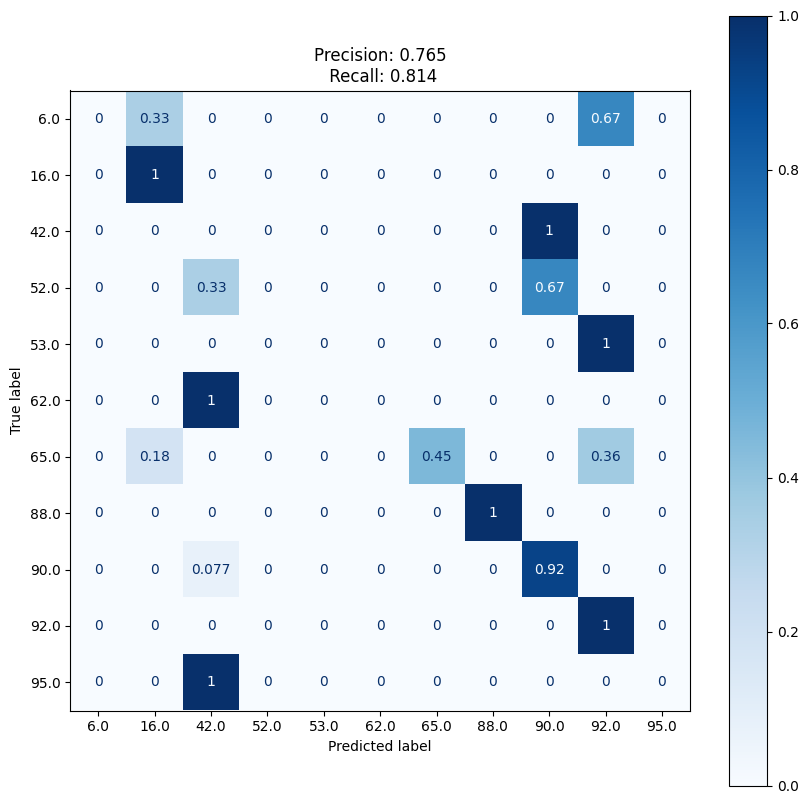

In [224]:
df = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/plasticc_train_lightcurves.csv')
df_meta = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/plasticc_train_metadata.csv')
df_names = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/plasticc_train_target_names.csv')
plasticc_lightcurve_features_df = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/Plasticc_Light_Curve_Feature_Data.csv')


# group lightcurves by object_id
grouped = df.groupby('object_id')
i = 0
series_list = []
series_names = []
for group, data in grouped:
    condition = (data['passband'] == 2) & (data['detected_bool'] == 1)
    
    flux = data.loc[condition, 'flux']
    mjd = data.loc[condition, 'mjd']

    ser = pd.Series(data=flux.values, index=mjd)
    if (len(ser) > 15):
        series_list.append(ser)
        series_names.append(group)
        i += 1

dataDict =  dict(zip(series_names, series_list))

file_path = 'plasticc_lightcurves_g.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(dataDict, file)

df_selected = df_meta[df_meta['object_id'].isin(series_names)]
file_path = 'plasticc_lightcurves_g_metadata.pkl'
# df_selected.to_pickle(file_path)

print (len(dataDict))

df_selected.loc[:, 'tflux_u-g'] = df_selected['tflux_u'] - df_selected['tflux_g']
df_selected.loc[:, 'tflux_g-r'] = df_selected['tflux_g'] - df_selected['tflux_r']
df_selected.loc[:, 'tflux_r-i'] = df_selected['tflux_r'] - df_selected['tflux_i']
df_selected.loc[:, 'tflux_i-z'] = df_selected['tflux_i'] - df_selected['tflux_z']

df_selected = plasticc_lightcurve_features_df.merge(df_selected, on='object_id', suffixes=('', '_y'))
df_selected = df_selected[df_selected.columns.drop(list(df_selected.filter(regex='_y')))]
# df_selected.columns

X, y = df_selected[['tflux_u-g', 'tflux_g-r', 'tflux_r-i', 'tflux_i-z','true_vpec', 'true_rv', 'true_av', 'true_distmod', 'true_lensdmu', 'feature', 'amplitude', 'percent_beyond_1_std', 'maximum', 'max_slope', 'median', 'median_absolute_deviation', 'percent_close_to_median', 'minimum', 'skew', 'std', 'period_fast', 'weighted_average',]], df_selected['target']

labels = np.unique(df_names['target']).tolist()
print('X.shape', X.shape)
print('y.shape', y.shape)

# split our data into training and validation sets
# setting random_state makes this split deterministic
(X_plasticc_train, X_plasticc_valid, X_plasticc_test), (y_plasticc_train, y_plasticc_valid, y_plasticc_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)

# train a Gaussian Mixture Bayes classifier with 2 gaussians for each class
gmmb = GMMBayes(n_components=9, random_state=0)
gmmb.fit(X_plasticc_train, y_plasticc_train)
print(f'Accuracy: {gmmb.score(X_plasticc_valid, y_plasticc_valid)}')

y_plasticc_pred = gmmb.predict(X_plasticc_valid)
labels_list = np.unique(y_plasticc_valid)

print(classification_report(y_plasticc_valid, y_plasticc_pred))
print(labels_list)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_plasticc_valid, y_plasticc_pred, display_labels=labels_list, cmap='Blues', ax=ax, normalize='true')
print('Stellar Type Recall %0.3f' % recall_score(y_plasticc_valid, y_plasticc_pred, average='weighted'))
print('Stellar Type Precision %0.3f' % precision_score(y_plasticc_valid, y_plasticc_pred, average='weighted'))
plt.title(f'Precision: {np.round(precision_score(y_plasticc_valid, y_plasticc_pred, average="weighted"), 3)}\n Recall: {np.round(recall_score(y_plasticc_valid, y_plasticc_pred, average="weighted"), 3)}')
plt.show()

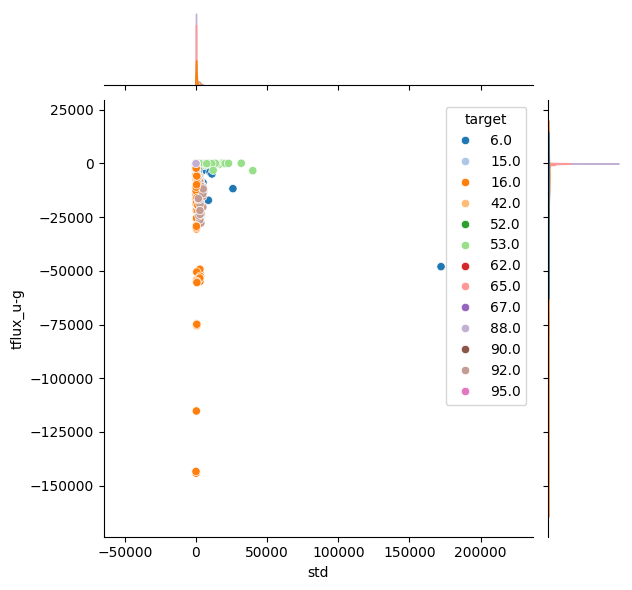

In [225]:
sns.jointplot(data=df_selected, x='std', y='tflux_u-g', hue='target', kind='scatter', palette='tab20')

<Figure size 2000x2000 with 0 Axes>

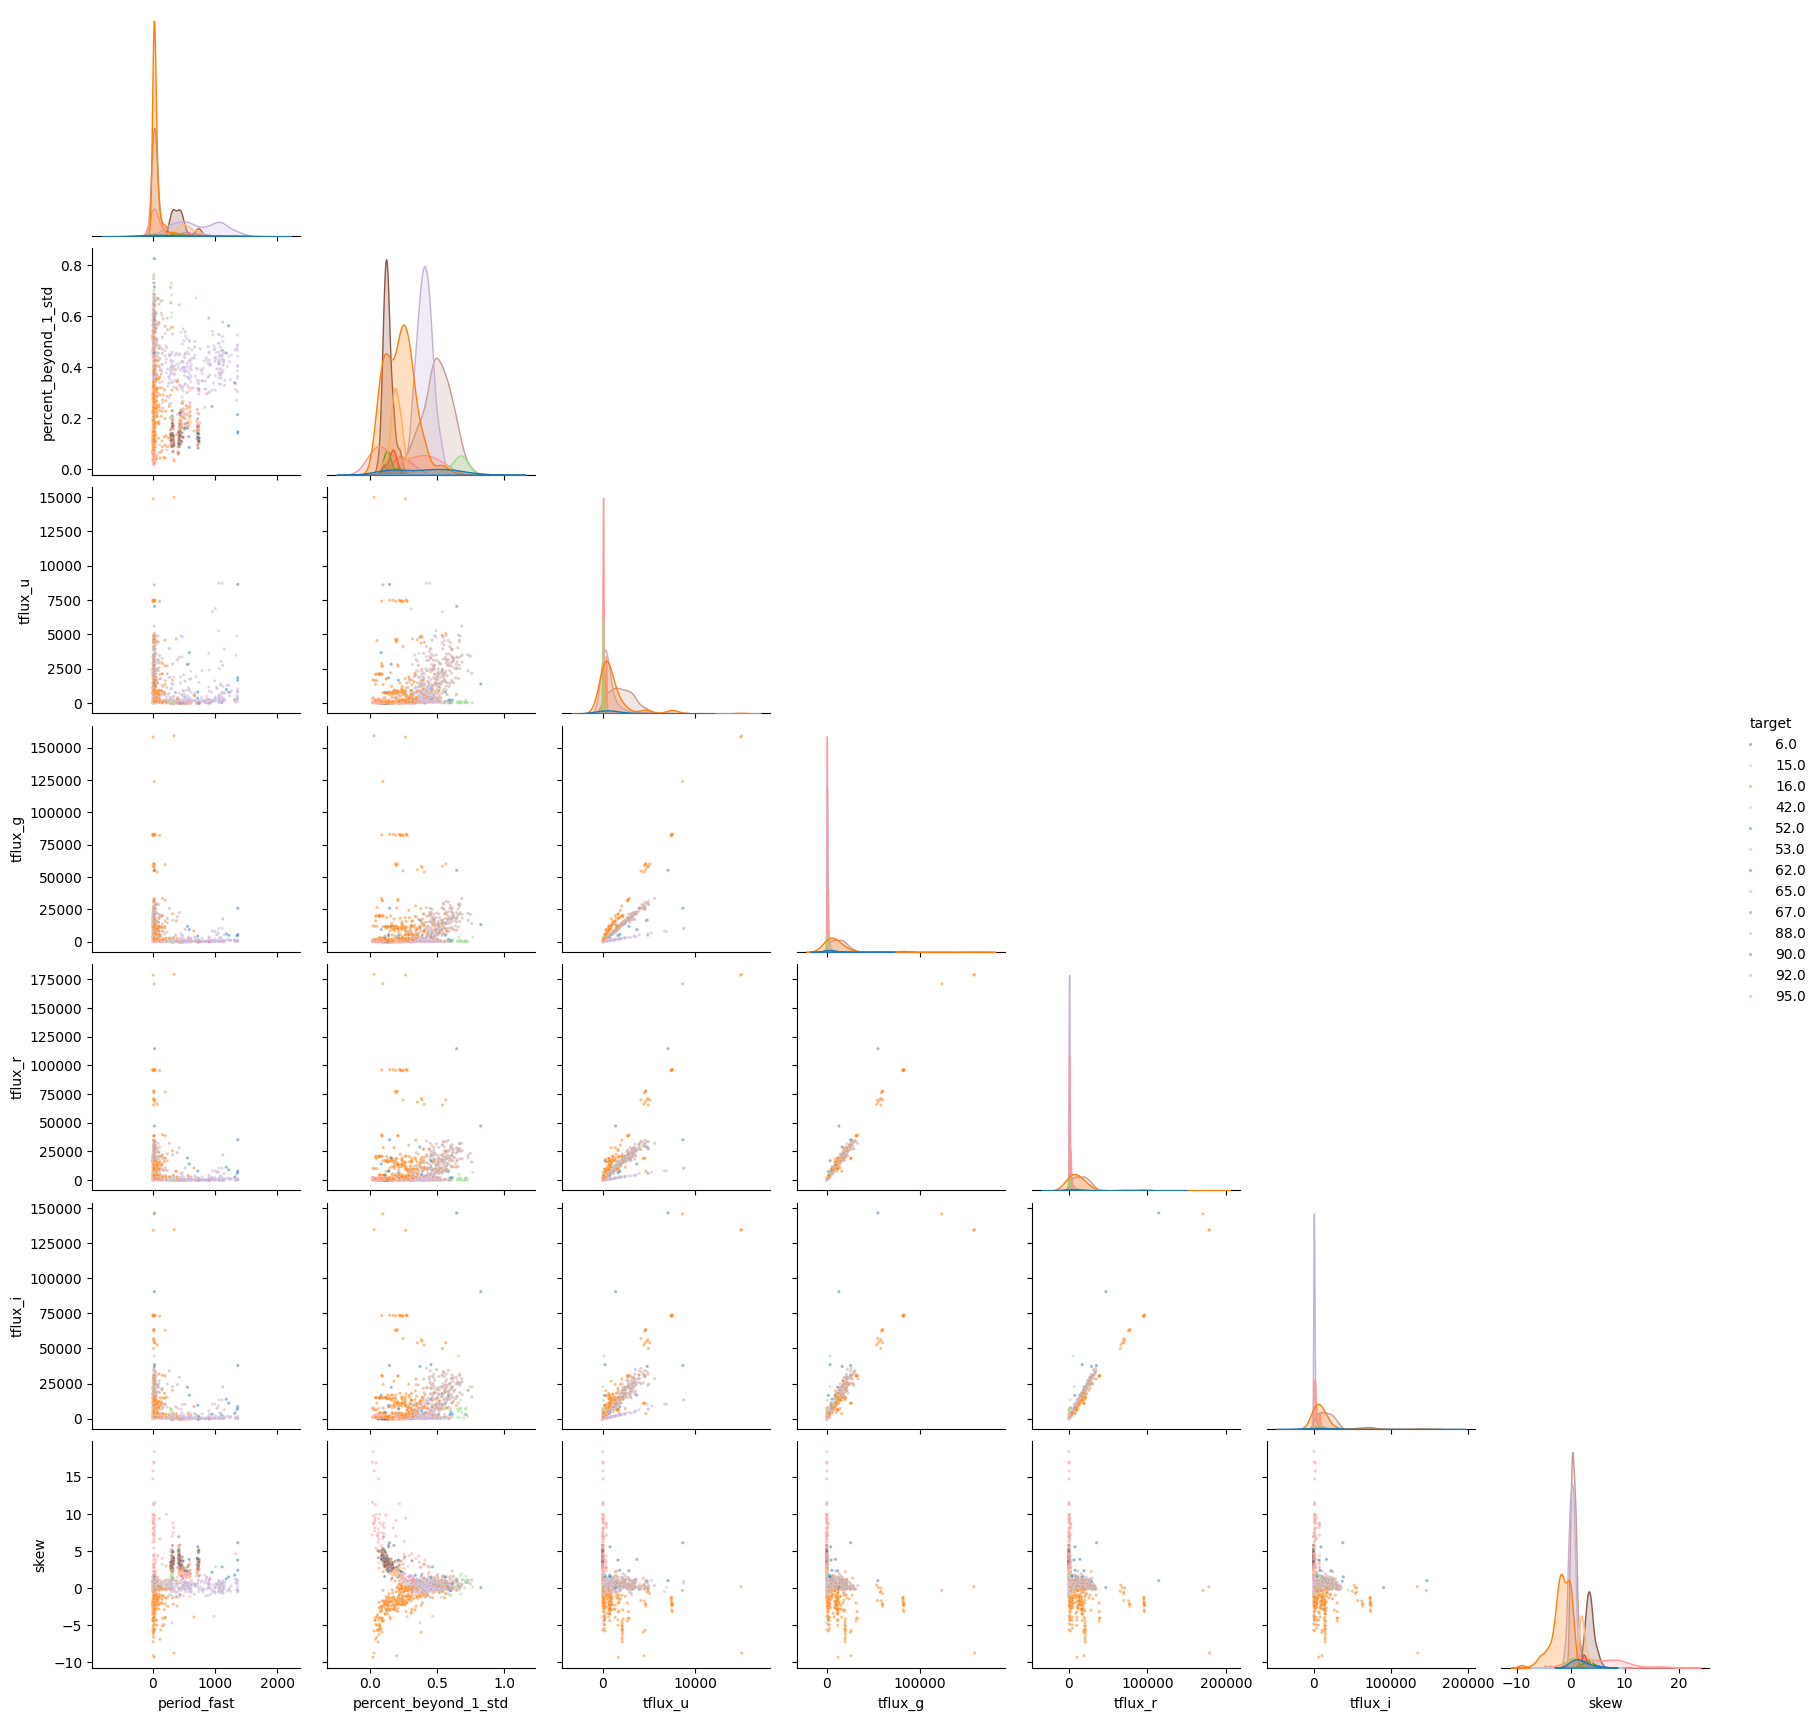

In [223]:
cols = ['period_fast',
 'percent_beyond_1_std',
 'tflux_u',
 'tflux_g',
 'tflux_r',
 'tflux_i',
 'skew']
fig = plt.figure(figsize=(20,20))
sns.pairplot(df_selected, 
            x_vars=cols,
            y_vars=cols,
            hue='target', palette='tab20',
            corner=True,
            plot_kws={'alpha':0.5, 's':5})



In [180]:
# # fetch the data and print its dimensions
# # X, y = fetch_rrlyrae_combined()
# X, y = df_selected[['tflux_u-g', 'tflux_g-r', 'tflux_r-i', 'tflux_i-z']], df_selected['target']
# features = ['u-g', 'g-r', 'r-i', 'i-z']
# # labels = ['non-variable', 'RR Lyrae']
# labels = np.unique(df_names['target']).tolist()
# print('X.shape', X.shape)
# print('y.shape', y.shape)

X.shape (1135, 4)
y.shape (1135,)


### GUSSAINS MIXTURE MODELS

In [183]:
df_selected.columns

Index(['object_id', 'ra', 'decl', 'ddf_bool', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target',
       'true_target', 'true_submodel', 'true_z', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y', 'tflux_u-g', 'tflux_g-r', 'tflux_r-i', 'tflux_i-z'],
      dtype='object')

In [186]:
df_selected = df_selected.merge(df_meta, on='object_id')
df_selected.columns

Index(['object_id', 'ra_x', 'decl_x', 'ddf_bool_x', 'hostgal_specz_x',
       'hostgal_photoz_x', 'hostgal_photoz_err_x', 'distmod_x', 'mwebv_x',
       'target_x', 'true_target_x', 'true_submodel_x', 'true_z_x',
       'true_distmod_x', 'true_lensdmu_x', 'true_vpec_x', 'true_rv_x',
       'true_av_x', 'true_peakmjd_x', 'libid_cadence_x', 'tflux_u_x',
       'tflux_g_x', 'tflux_r_x', 'tflux_i_x', 'tflux_z_x', 'tflux_y_x',
       'tflux_u-g', 'tflux_g-r', 'tflux_r-i', 'tflux_i-z', 'ra_y', 'decl_y',
       'ddf_bool_y', 'hostgal_specz_y', 'hostgal_photoz_y',
       'hostgal_photoz_err_y', 'distmod_y', 'mwebv_y', 'target_y',
       'true_target_y', 'true_submodel_y', 'true_z_y', 'true_distmod_y',
       'true_lensdmu_y', 'true_vpec_y', 'true_rv_y', 'true_av_y',
       'true_peakmjd_y', 'libid_cadence_y', 'tflux_u_y', 'tflux_g_y',
       'tflux_r_y', 'tflux_i_y', 'tflux_z_y', 'tflux_y_y', 'ra', 'decl',
       'ddf_bool', 'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err',
       'dist

#### Plot distrubutions

In [25]:
# # make the plots look nice
# mpl.rcParams['figure.dpi'] = 150
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
# plt.rc('legend', fontsize='x-small')
# # cmap = cm.get_cmap('viridis')
# cmap = plt.get_cmap('viridis')

# # convenience function to turn 2D covariance matrix into semi-major/minor axis and position angle of error ellipse
# def covariance_to_vangle(covariance):
#     # adapted from "GMM Covariances"
#     # https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html
#     v, w = np.linalg.eigh(covariance)
#     u = w[0] / np.linalg.norm(w[0])
#     angle = np.arctan2(u[1], u[0])
#     angle = 180 * angle / np.pi  # convert to degrees
#     v = 2. * np.sqrt(2.) * np.sqrt(v)
#     return v, angle

# def scatter_gmmb(ax, i, j):
#     idx = [i,j]
#     rows = [[i, i], [j, j]]
#     cols = [[i, j], [i, j]]
        
#     for k in range(2): # for each class
#         for l in range(gmmb.gmms_[k].n_components): # for each Gaussian
#             covariance = gmmb.gmms_[k].covariances_[l][rows, cols]
            
#             v, angle = covariance_to_vangle(covariance)
            
#             ell = mpl.patches.Ellipse(gmmb.gmms_[k].means_[l, idx], v[0], v[1],
#                                       180 + angle, ec=cmap(float(k)), fill=False)
#             ell.set_alpha(gmmb.gmms_[k].weights_[l])
#             ax.add_artist(ell)

# def hist_gmmb(ax, i):
#     plotx = np.linspace(np.min(X[:,i]), np.max(X[:,i]), 100)
#     for k in range(2): # for each class
#         for l in range(gmmb.gmms_[k].n_components): # for each Gaussian
#             dist = norm(loc=gmmb.gmms_[k].means_[l,i], scale=np.sqrt(gmmb.gmms_[k].covariances_[l][i,i]))
#             plt.plot(plotx, dist.pdf(plotx), color=cmap(float(k)), alpha=gmmb.gmms_[k].weights_[l])

            
# def plot_rrlyrae(scatterfn=None, histfn=None):    
#     fig = plt.figure(figsize=(6,6))
#     fig.subplots_adjust(hspace=0, wspace=0)

#     # loop through every possible pair of features
#     for i in range(4):
#         for j in range(4):
#             # only make subplots in the lower diagonal
#             if i <= j:
#                 ax = plt.subplot(4,4,i+j*4+1)
#                 # if this subplot is on the left side (but not the top), make a y label
#                 if i == 0 and j != 0:
#                     ax.set_ylabel(features[j])
#                 # if this subplot is on the bottom, make an x label
#                 if j == 3:
#                     ax.set_xlabel(features[i])
#                 # remove ticks on interior plots
#                 if i != 0:
#                     ax.set_yticks([])
#                 if j != 3:
#                     ax.set_xticks([])
#                 # scatter plots in off diagonals
#                 if i < j:
#                     ax.scatter(X[y==0,i], X[y==0,j], s=1, marker='.', c=y[y==0], vmin=0, vmax=1, alpha=0.005)
#                     ax.scatter(X[y==1,i], X[y==1,j], s=1, marker='.', c=y[y==1], vmin=0, vmax=1, alpha=0.25)
#                     if scatterfn is not None:
#                         scatterfn(ax, i, j)
#                     ax.set_xlim(np.min(X[:,i]), np.max(X[:,i]))
#                     ax.set_ylim(np.min(X[:,j]), np.max(X[:,j]))
#                 # normalized histograms on diagonals, with same colour map as scatter plots
#                 if i == j:
#                     plt.hist([X[y == 0, i], X[y == 1, i]], density=True, histtype='stepfilled',\
#                              label=labels, color=[cmap(0.), cmap(1.)], alpha=0.5)

#                     if histfn is not None:
#                         histfn(ax, i)

#                     plt.yticks([]) # don't want counts in the y-axis
#                     # add a legend
#                     if i == 0:
#                         plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', title='labels')
#     plt.show()


# plot_rrlyrae(scatterfn=scatter_gmmb, histfn=hist_gmmb)

In [102]:
plasticc_lightcurve_features_df = pd.read_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/Plasticc_Light_Curve_Feature_Data.csv')

plasticc_lightcurve_features_df.head()

,feature,amplitude,percent_beyond_1_std,maximum,max_slope,median,median_absolute_deviation,percent_close_to_median,minimum,skew,...,period_fast,weighted_average,object_id,target,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,channel,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,880.533203,0.392045,660.626343,116805.166334,-89.477524,294.582848,0.315341,-1100.440063,-0.348049,...,342.126194,-87.644684,615.0,92.0,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
2,0,14.753032,0.425714,14.770886,1580.576999,-0.873033,5.323984,0.217143,-14.735178,0.014925,...,1061.024750,-1.445298,713.0,88.0,108.7,117.7,119.9,149.6,147.9,150.5
3,0,33.234935,0.154545,47.310059,3949.860787,0.409172,1.658209,0.872727,-19.159811,3.163391,...,419.374018,1.436777,730.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,118.144837,0.082621,220.795212,11188.062767,1.035895,2.252309,0.908832,-15.494463,4.958519,...,728.418089,6.090088,745.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
plasticc_lightcurve_features_df.loc[:, 'tflux_u-g'] = plasticc_lightcurve_features_df['tflux_u'] - plasticc_lightcurve_features_df['tflux_g']
plasticc_lightcurve_features_df.loc[:, 'tflux_g-r'] = plasticc_lightcurve_features_df['tflux_g'] - plasticc_lightcurve_features_df['tflux_r']
plasticc_lightcurve_features_df.loc[:, 'tflux_r-i'] = plasticc_lightcurve_features_df['tflux_r'] - plasticc_lightcurve_features_df['tflux_i']
plasticc_lightcurve_features_df.loc[:, 'tflux_i-z'] = plasticc_lightcurve_features_df['tflux_i'] - plasticc_lightcurve_features_df['tflux_z']

In [126]:
columns = plasticc_lightcurve_features_df.columns.to_list() 
column_without_target = [col for col in columns if col != 'target']
column_without_target

['feature',
 'amplitude',
 'percent_beyond_1_std',
 'maximum',
 'max_slope',
 'median',
 'median_absolute_deviation',
 'percent_close_to_median',
 'minimum',
 'skew',
 'std',
 'period_fast',
 'weighted_average',
 'object_id',
 'tflux_u',
 'tflux_g',
 'tflux_r',
 'tflux_i',
 'tflux_z',
 'tflux_y',
 'tflux_u-g',
 'tflux_g-r',
 'tflux_r-i',
 'tflux_i-z']

In [128]:
len(column_without_target)

24

In [141]:
labels = np.unique(plasticc_lightcurve_features_df['target'])
labels


array([ 6., 15., 16., 42., 52., 53., 62., 64., 65., 67., 88., 90., 92.,
       95., nan])

X.shape (7849, 21)
y.shape (7849,)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

         6.0       0.85      0.69      0.76        16
        15.0       0.18      0.26      0.21        38
        16.0       0.97      1.00      0.98        98
        42.0       0.40      0.26      0.31       120
        52.0       0.14      0.06      0.08        17
        53.0       0.00      0.00      0.00         1
        62.0       0.23      0.21      0.22        43
        64.0       0.25      0.09      0.13        11
        65.0       1.00      1.00      1.00        96
        67.0       0.03      0.06      0.04        18
        88.0       1.00      0.95      0.97        39
        90.0       0.56      0.66      0.61       247
        92.0       0.71      1.00      0.83        17
        95.0       0.36      0.17      0.23        24

    accuracy                           0.61       785
   macro avg       0.48      0.46      0.46       785
weighted avg       0.60      0.61      0.60       785

Stellar Type Recall 0.610

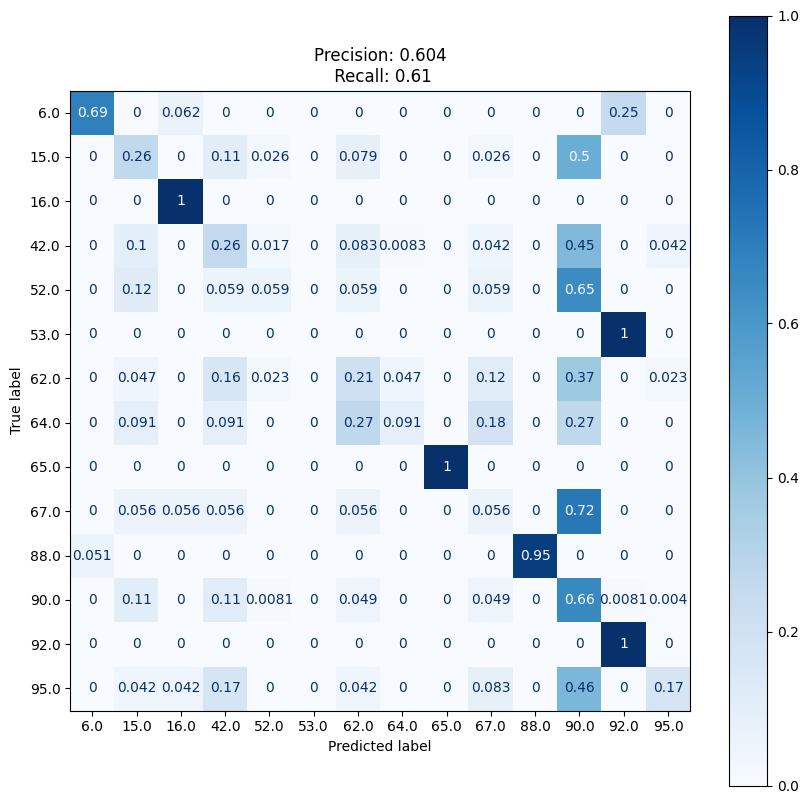

In [165]:
# fetch the data and print its dimensions
X, y = plasticc_lightcurve_features_df[['feature',
 'amplitude',
 'percent_beyond_1_std',
 'maximum',
 'max_slope',
 'median',
 'median_absolute_deviation',
 'percent_close_to_median',
 'minimum',
 'skew',
 'std',
 'period_fast',
 'weighted_average',
 'tflux_u',
 'tflux_g',
 'tflux_r',
 'tflux_i',
 'tflux_u-g',
 'tflux_g-r',
 'tflux_r-i',
 'tflux_i-z']], plasticc_lightcurve_features_df['target']

# features = ['u-g', 'g-r', 'r-i', 'i-z']
# labels = ['non-variable', 'RR Lyrae']
# labels = np.unique(plasticc_lightcurve_features_df['target']).tolist()
print('X.shape', X.shape)
print('y.shape', y.shape)

# split our data into training and validation sets
# setting random_state makes this split deterministic
(X_plasticc_train, X_plasticc_valid, X_plasticc_test), (y_plasticc_train, y_plasticc_valid, y_plasticc_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)
labels = np.unique(y_plasticc_valid).astype('str')


# train a Gaussian Mixture Bayes classifier with 2 gaussians for each class
gmmb = GMMBayes(n_components=14, random_state=0)
gmmb.fit(X_plasticc_train, y_plasticc_train)
y_plasticc_pred = gmmb.predict(X_plasticc_valid)



# print(f'Accuracy: {gmmb.score(X_plasticc_valid, y_plasticc_valid)}')
print(classification_report(y_plasticc_valid, y_plasticc_pred))

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot()
# ConfusionMatrixDisplay.from_predictions(y_plasticc_valid, y_plasticc_pred, display_labels=labels_list, cmap='Blues', ax=ax)
# # plt.title(f'Recall:{}, Precision:{}')
# plt.title(f'Accuracy: {gmmb.score(X_plasticc_valid, y_plasticc_valid)}')
# plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_plasticc_valid, y_plasticc_pred, display_labels=labels, cmap='Blues', ax=ax, normalize='true')
print('Stellar Type Recall %0.3f' % recall_score(y_plasticc_valid, y_plasticc_pred, average='weighted'))
print('Stellar Type Precision %0.3f' % precision_score(y_plasticc_valid, y_plasticc_pred, average='weighted'))
plt.title(f'Precision: {np.round(precision_score(y_plasticc_valid, y_plasticc_pred, average="weighted"), 3)}\n Recall: {np.round(recall_score(y_plasticc_valid, y_plasticc_pred, average="weighted"), 3)}')
plt.show()

<Axes: ylabel='Count'>

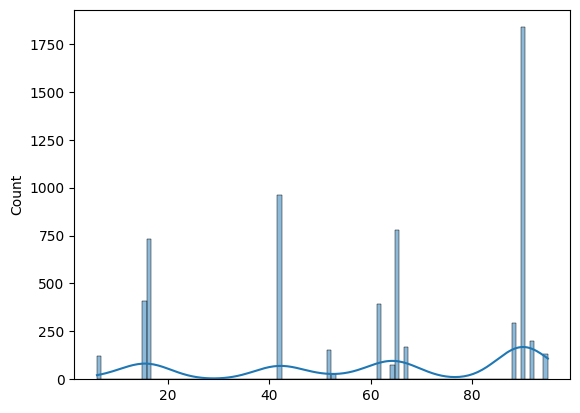

In [158]:
sns.histplot(y_plasticc_train, bins=100, kde=True)

<Axes: ylabel='Count'>

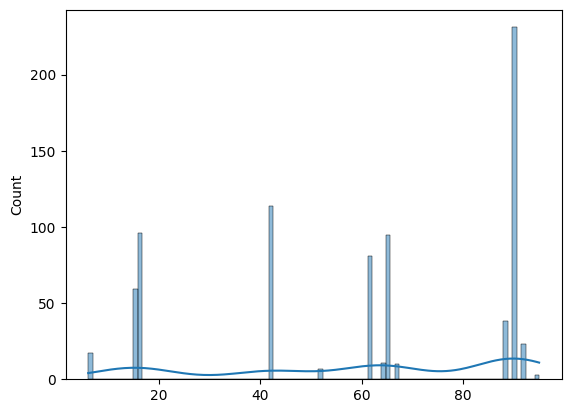

In [156]:
sns.histplot(y_plasticc_pred, bins=100, kde=True)

<Axes: ylabel='Count'>

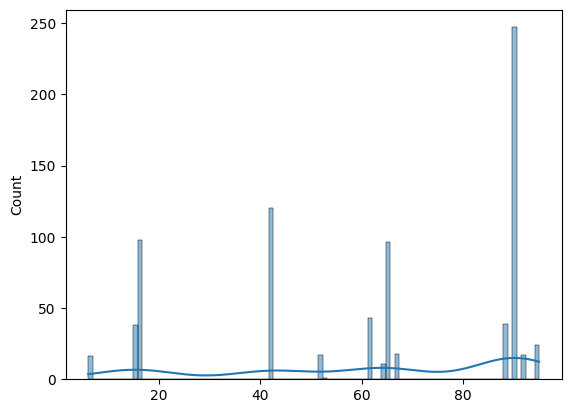

In [155]:
sns.histplot(y_plasticc_valid, bins=100, kde=True)